In [1]:
import _init_paths
import nengo_dl
import nengo
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pickle

from configs.exp_configs import tf_exp_cfg as exp_cfg, nengo_dl_cfg as ngo_cfg
from utils.base_utils.data_prep_utils import get_batches_of_cifar_data
from utils.base_utils.exp_utils import collect_sim_data_spikes
from utils.nengo_dl_utils import get_nengo_dl_model
from utils.consts.dir_consts import EXP_OTPT_DIR
from utils.consts.exp_consts import SEED

/home/rgaurav/miniconda3/envs/nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:360: UserWarning: Layer '<class 'tensorflow.python.keras.layers.normalization_v2.BatchNormalization'>' already has a converter. Overwriting.
  "Layer '%s' already has a converter. Overwriting." % keras_layer


# Get the batched Test Data, the Nengo-DL Model

In [2]:
batches = get_batches_of_cifar_data(ngo_cfg, is_test=True)
nengo_model, nengo_probes_obj_lst = get_nengo_dl_model(
    (32, 32, 3), exp_cfg, ngo_cfg)

/home/rgaurav/miniconda3/envs/nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:555: UserWarning: Activation type <function softmax at 0x2af0a94783b0> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [3]:
print(exp_cfg)
print(ngo_cfg)

{'rf': 5e-05, 'batch_size': 64, 'epochs': 16, 'lr': 0.0001, 'nn_dlyr': 10, 'tf_model': {'name': 'model_1', 'layers': {'layer_1': Layer(num_kernels=32, kernel_dims=(3, 3), stride_dims=(1, 1)), 'layer_2': Layer(num_kernels=64, kernel_dims=(3, 3), stride_dims=(1, 1)), 'layer_3': Layer(num_kernels=64, kernel_dims=(3, 3), stride_dims=(2, 2)), 'layer_4': Layer(num_kernels=96, kernel_dims=(3, 3), stride_dims=(2, 2)), 'layer_5': Layer(num_kernels=128, kernel_dims=(3, 3), stride_dims=(2, 2))}}, 'tf_wts_otpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/tf_trained_wts/'}
{'tf_wts_inpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/tf_trained_wts/weights', 'ndl_res_otpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/ndl_relu_results/', 'spk_neuron': RectifiedLinear(), 'synapse': None, 'sfr': 1, 'n_steps': 1, 'test_batch_size': 100, 'train_batch_size': 16}



# Create the Simulator and do inference

In [4]:
ndl_model_otpt = []
ndl_model_spks = []

with nengo_model.net:
  nengo_dl.configure_settings(stateful=False)

with nengo_dl.Simulator(
  nengo_model.net, minibatch_size=ngo_cfg["test_batch_size"], progress_bar=True, seed=SEED) as sim:
  nengo_input = nengo_probes_obj_lst[0]
  nengo_output = nengo_probes_obj_lst[-1]
  batch_num=1
  for batch in batches:
    sim_data = sim.predict_on_batch({nengo_input: batch[0]})
    for y_true, y_pred in zip(batch[1], sim_data[nengo_output]):
      ndl_model_otpt.append((np.argmax([y_true]), np.argmax(y_pred[-1]), y_pred))
    if batch_num == 1: # Collect only for one batch, else memory consumption is too high.
      mdl_spks = collect_sim_data_spikes(nengo_probes_obj_lst, sim_data)
      ndl_model_spks.extend(mdl_spks)
    print("Batch: %s Done." % batch_num)
    batch_num += 1

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               
Batch: 1 Done.


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Batch: 1 Done.
Batch: 2 Done.
Batch: 3 Done.
Batch: 4 Done.
Batch: 5 Done.
Batch: 6 Done.
Batch: 7 Done.
Batch: 8 Done.
Batch: 9 Done.
Batch: 10 Done.
Batch: 11 Done.
Batch: 12 Done.
Batch: 13 Done.
Batch: 14 Done.
Batch: 15 Done.
Batch: 16 Done.
Batch: 17 Done.
Batch: 18 Done.
Batch: 19 Done.
Batch: 20 Done.
Batch: 21 Done.
Batch: 22 Done.
Batch: 23 Done.
Batch: 24 Done.
Batch: 25 Done.
Batch: 26 Done.
Batch: 27 Done.
Batch: 28 Done.
Batch: 29 Done.
Batch: 30 Done.
Batch: 31 Done.
Batch: 32 Done.
Batch: 33 Done.
Batch: 34 Done.
Batch: 35 Done.
Batch: 36 Done.
Batch: 37 Done.
Batch: 38 Done.
Batch: 39 Done.
Batch: 40 Done.
Batch: 41 Done.
Batch: 42 Done.
Batch: 43 Done.
Batch: 44 Done.
Batch: 45 Done.
Batch: 46 Done.
Batch: 47 Done.
Batch: 48 Done.
B

Layer: <Neurons of <Ensemble "dense_1.0">>, Neuron Type: RectifiedLinear(), Number of Neurons: 512, Seed: None
Unique Encoders: [-1.  1.]
Unique Scaled Encoders: [-1.  1.]
Unique bias: [-4.45359014e-02 -4.39157635e-02 -4.28015292e-02 -4.23861071e-02
 -3.90870944e-02 -3.84859219e-02 -3.66398767e-02 -3.61575969e-02
 -3.56843993e-02 -3.49964462e-02 -3.49262804e-02 -3.46531048e-02
 -3.43387686e-02 -3.18478942e-02 -3.13309878e-02 -3.09199858e-02
 -3.04724611e-02 -2.88963076e-02 -2.86277123e-02 -2.82096434e-02
 -2.79821474e-02 -2.77507305e-02 -2.76334658e-02 -2.75955778e-02
 -2.73877624e-02 -2.66874582e-02 -2.66825333e-02 -2.58017667e-02
 -2.54397076e-02 -2.50841063e-02 -2.40296200e-02 -2.39173863e-02
 -2.38291621e-02 -2.37126984e-02 -2.35028751e-02 -2.33146325e-02
 -2.29091346e-02 -2.28175633e-02 -2.25290339e-02 -2.20454708e-02
 -2.09044069e-02 -2.06733812e-02 -2.02576742e-02 -2.02167984e-02
 -1.96096413e-02 -1.94516480e-02 -1.94382109e-02 -1.89421475e-02
 -1.87904593e-02 -1.83191374e-02 -1

Batch: 100 Done.


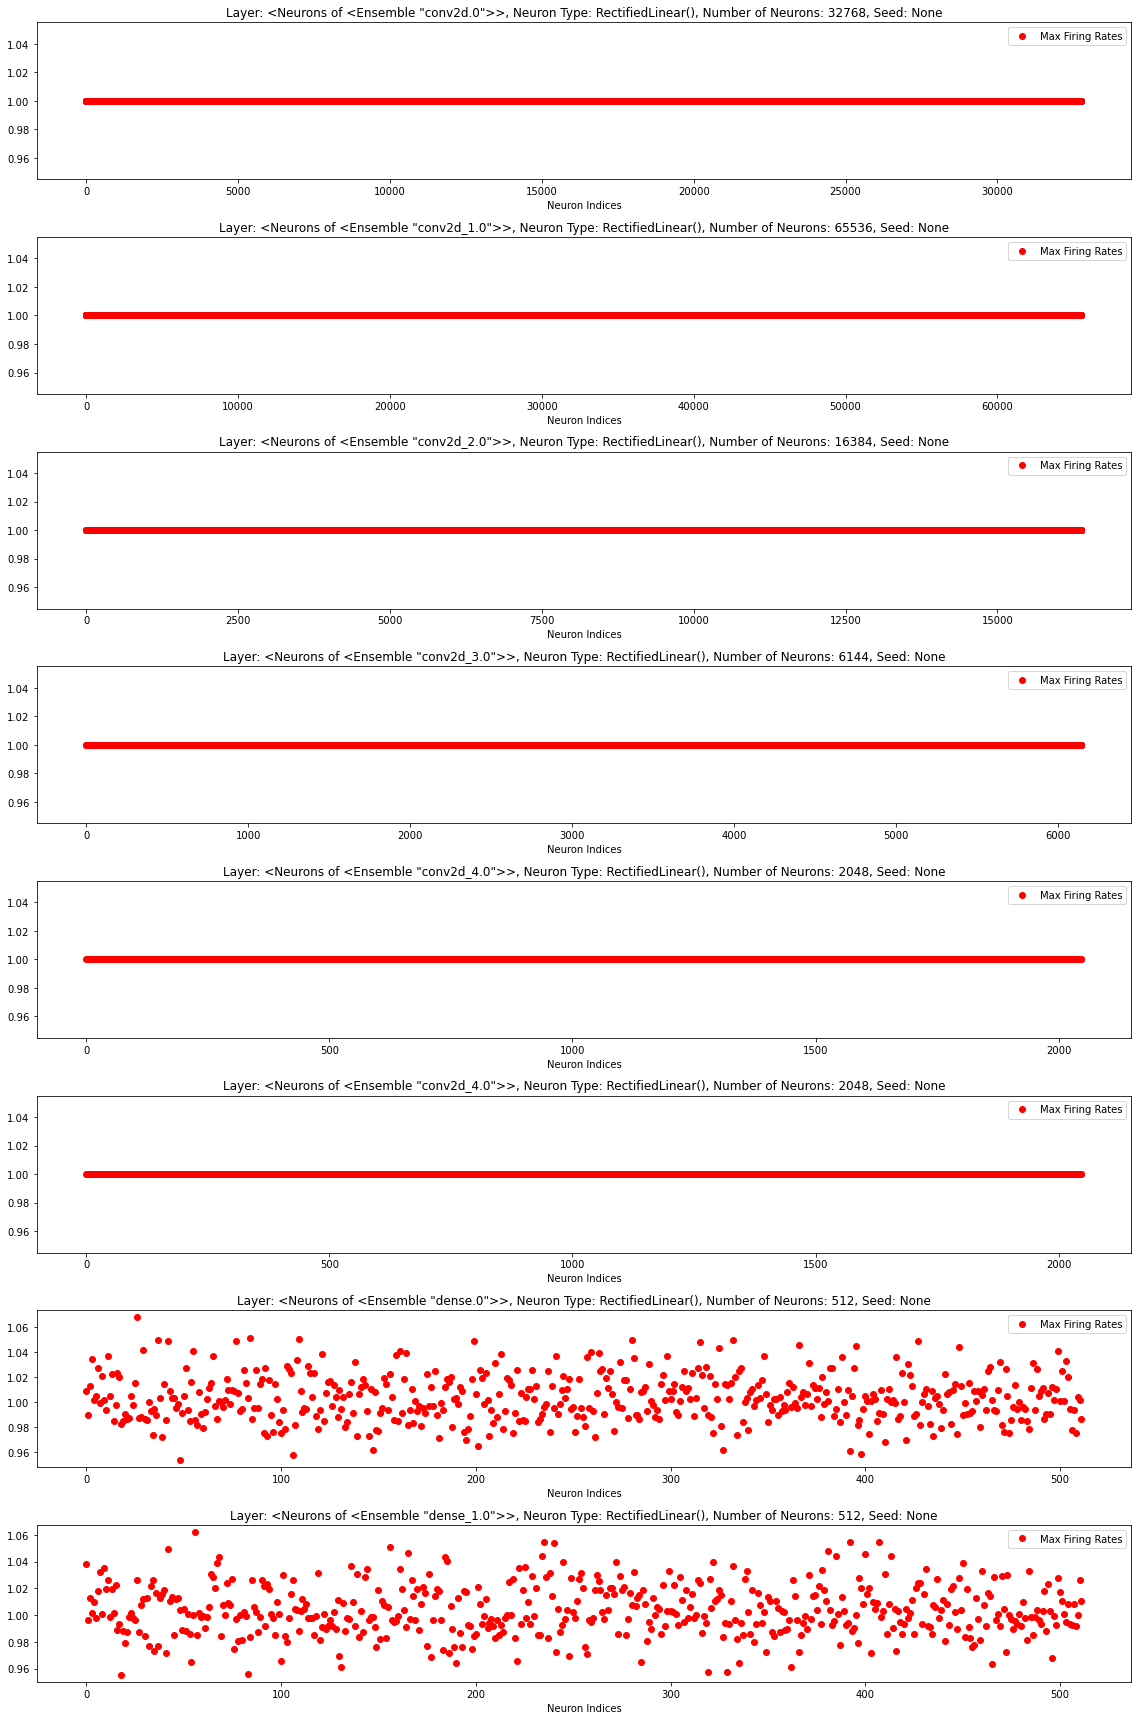

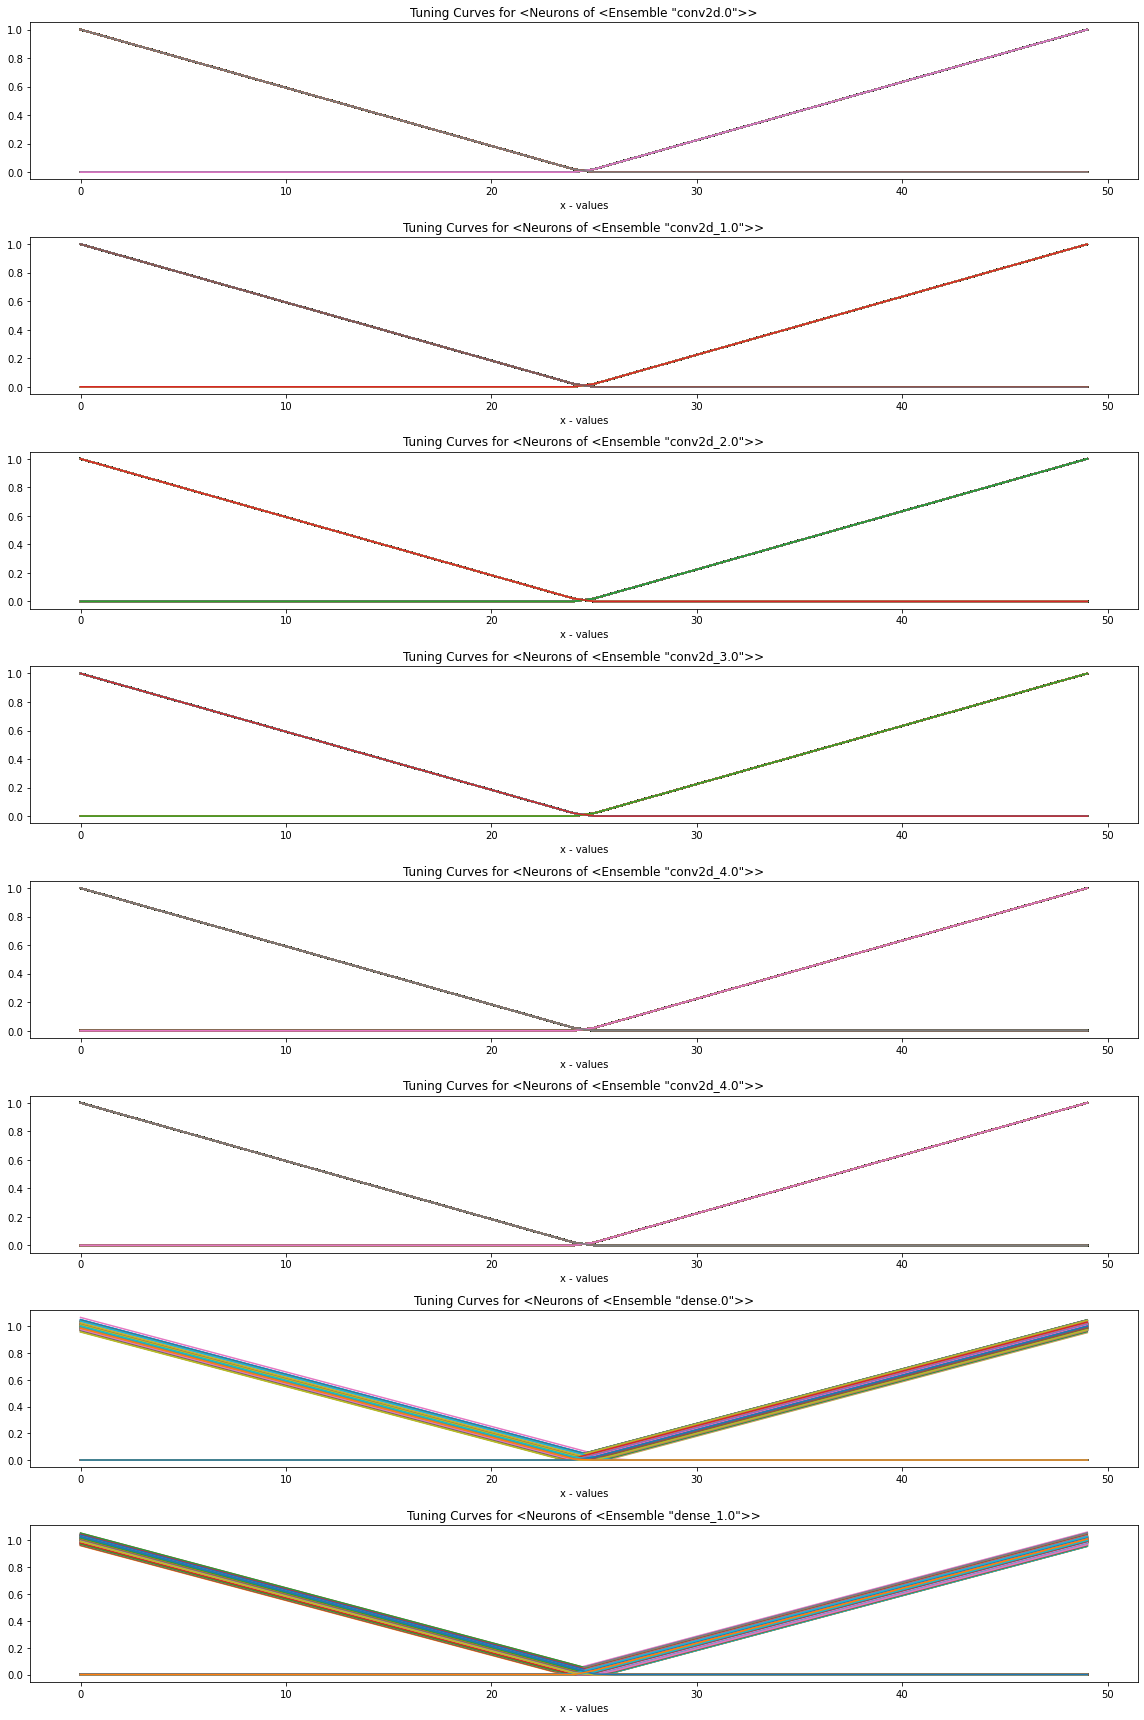

In [4]:
ndl_model_otpt = []
ndl_model_spks = []

with nengo_model.net:
  nengo_dl.configure_settings(stateful=False)

with nengo_dl.Simulator(
  nengo_model.net, minibatch_size=ngo_cfg["test_batch_size"], progress_bar=True, seed=SEED) as sim:
  nengo_input = nengo_probes_obj_lst[0]
  nengo_output = nengo_probes_obj_lst[-1]
  batch_num=1
  for batch in batches:
    sim_data = sim.predict_on_batch({nengo_input: batch[0]})
    for y_true, y_pred in zip(batch[1], sim_data[nengo_output]):
      ndl_model_otpt.append((np.argmax([y_true]), np.argmax(y_pred[-1]), y_pred))
    if batch_num == 1: # Collect only for one batch, else memory consumption is too high.
      mdl_spks = collect_sim_data_spikes(nengo_probes_obj_lst, sim_data)
      ndl_model_spks.extend(mdl_spks)
    print("Batch: %s Done." % batch_num)
    batch_num += 1
    if batch_num == 100:
        layers = list(nengo_model.layers.dict.values())[1:-1]
        fig, axs = plt.subplots(len(layers), figsize=(16, 3*len(layers)))
        fig1, axs1 = plt.subplots(len(layers), figsize=(16, 3*len(layers)))
        for i, layer in enumerate(layers):
            ens = layer.ensemble
            axs[i].set_title("Layer: {0}, Neuron Type: {1}, Number of Neurons: {2}, Seed: {3}".format(
                ens.neurons, ens.neuron_type, ens.n_neurons, ens.seed))
            axs[i].plot(sim.data[ens].max_rates, 'ro', label="Max Firing Rates")
            print("Layer: {0}, Neuron Type: {1}, Number of Neurons: {2}, Seed: {3}".format(
                ens.neurons, ens.neuron_type, ens.n_neurons, ens.seed))
            print("Unique Encoders: {}".format(np.unique(sim.data[ens].encoders)))
            print("Unique Scaled Encoders: {}".format(np.unique(sim.data[ens].scaled_encoders)))
            print("Unique bias: {}".format(np.unique(sim.data[ens].bias)))
            print("Unique gain: {}".format(np.unique(sim.data[ens].gain)))
            print("Unique intercepts: {}".format(np.unique(sim.data[ens].intercepts)))
            axs[i].legend()
            axs[i].set_xlabel("Neuron Indices")
            print("*"*100)
            axs1[i].set_title("Tuning Curves for {}".format(ens.neurons))
            x, act_mat = nengo.utils.ensemble.tuning_curves(ens, sim)
            for j in range(ens.n_neurons):
                axs1[i].plot(act_mat[:, j])
            axs1[i].set_xlabel("x - values")
        fig.tight_layout()
        fig.show()
        fig1.tight_layout()
        fig1.show()

In [6]:
pickle.dump({"acc_res": ndl_model_otpt, "spk_res": ndl_model_spks}, 
            open(ngo_cfg["ndl_res_otpt_dir"]+"ndl_%s_results_sfr_%s_nstps_%s.p" 
                % (exp_cfg["tf_model"]["name"], ngo_cfg["sfr"], ngo_cfg["n_steps"]), "wb"))

In [5]:
acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)

0.6504


In [5]:
# SFR = 1, N_STEPS=80, ACC: 10% random (No layer spikes)
# SFR = 50, N_STEPS=80, ACC: 42.1 (output layer starts spiking after 70ms)
# SFR = 100, N_STEPS=80, ACC: 60.73 (output layer starts spiking after 50ms)
# SFR = 200, N_STEPS=80, ACC: 63.85 (output layer starts spiking after 35ms)
# SFR = 250, N_STEPS=80, ACC: 64.56 (output layer starts spiking after 30ms)
# SFR = 600, N_STEPS=80, ACC: 64.98 (output layer starts spiking after 20ms)


# SFR = 250, N_STEPS=60, ACC: 63.85 (Same spiking pattern as N_STEPS=80)
# SFR = 250, N_STEPS=55, ACC: 62.21 (Same spiking pattern as N_STEPS=80)
# SFR = 250, N_STEPS=50, ACC: 60.02 (Same spiking pattern as N_STEPS=80)
# SFR = 250, N_STEPS=40, ACC: 40.87 (Same spiking pattern as N_STEPS=80)


# As you lower down the SFR (and keep the N_STEPS fixed), it takes longer for the output layer to spike.
# 

acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)

0.6383
